## Cleaning the data with help of our first model
Before we dive into different options for modelling, we will do a quick pass through the data and see which images are bad.

The background is that the scrapper pick up all sort of images, which are not good for training.

We start by creating a working copy of the dataset.

In [185]:
!mkdir -p working/which_cheese_first 
!cp -r cheese/which_cheese  working/which_cheese_first 

To be sure that all images are valid, we check again for corrupeted files and remove them.

In [188]:
from pathlib import Path
from PIL import Image

data_path = Path("working/which_cheese_first")

# Check all images
corrupt_files = []
for img_path in data_path.rglob("*.*"):  # Match all files inside subfolders
    try:
        with Image.open(img_path) as img:
            img.verify()  # Verify if it's a valid image
    except (IOError, SyntaxError):
        corrupt_files.append(img_path)

# Remove corrupt images
print(f"Found {len(corrupt_files)} corrupt images.")
for corrupt in corrupt_files:
    print(f"Deleting {corrupt}")
    corrupt.unlink()  # Delete the file


Found 48 corrupt images.
Deleting working/which_cheese_first/which_cheese/Roquefort/350d3e67-dcf6-4292-b963-c1d5841b8788.jpg
Deleting working/which_cheese_first/which_cheese/Roquefort/594d40b1-f655-4db1-b3a9-4e7d6bb6c631.jpg
Deleting working/which_cheese_first/which_cheese/Roquefort/32a9069e-52c2-47e1-9db4-16197556c4fb.jpg
Deleting working/which_cheese_first/which_cheese/Roquefort/c73fb213-3813-43fd-b5ae-2d390ca8e3d5.jpg
Deleting working/which_cheese_first/which_cheese/Roquefort/2c426320-24bd-4869-8f1c-d09171ac6294.jpg
Deleting working/which_cheese_first/which_cheese/Roquefort/83a95414-4083-48d7-9956-be5d82b05caf.jpg
Deleting working/which_cheese_first/which_cheese/Roquefort/f4f09c62-652b-400c-8e09-419389635fc4.jpg
Deleting working/which_cheese_first/which_cheese/Roquefort/dfa07f3c-0931-49aa-b3c2-9c4a5901565d.jpg
Deleting working/which_cheese_first/which_cheese/Roquefort/609abf59-c1f0-4a34-b2cf-1bedf1b4cea0.jpg
Deleting working/which_cheese_first/which_cheese/Roquefort/b56ab8cc-5b37-40

### Model definition
We will define a simple model and check if the data is loaded correctly. The most simple model for image classification is `resnet18`.

In [181]:
from fastcore.all import *
from fastai.vision.all import *

In [182]:
cheese = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
)

In [189]:
dls = cheese.dataloaders("working/which_cheese_first")

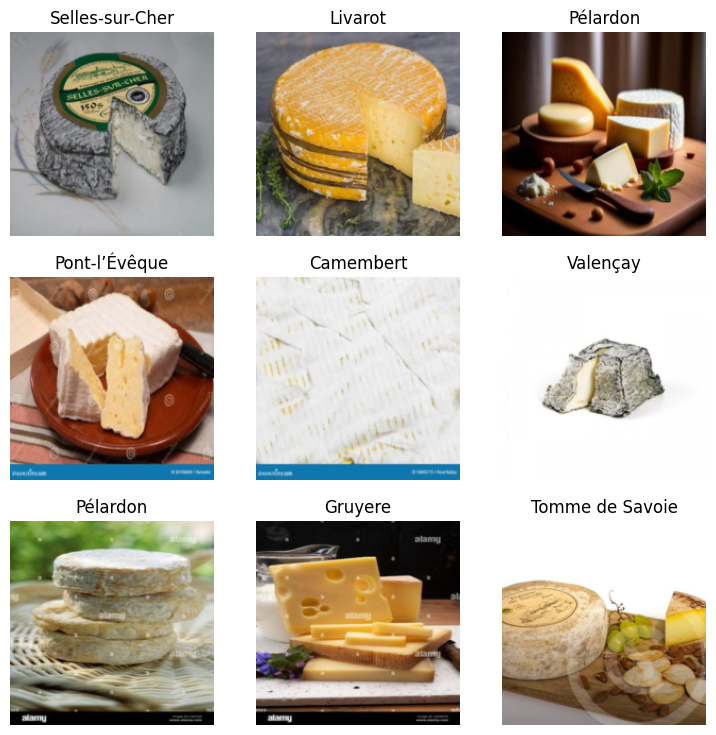

In [190]:
dls.show_batch()

For the metrics, I chose `accuracy` as this is the most easy to interprate. We will later see that the dataset becomes slightly imbalenced in training and `F1-score` would be better.

In [191]:
learn = vision_learner(dls, resnet18, metrics=accuracy)

We then do a quick learning pass.

In [192]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,4.307302,2.287525,0.356164,00:02


epoch,train_loss,valid_loss,accuracy,time
0,2.265255,1.649305,0.547945,00:03
1,1.552460,1.265489,0.662100,00:03
2,1.129812,1.213783,0.666667,00:03


As we can see accuracy increased to 66% after 3 epochs.

## Data Cleaning
We can have a look at the confusion matrix. There are some cheeses that are easily confused with each other. For example `Bleu d'Auvergne` with `Fourme d'Ambert`. In fact in cheese stores outside France, few people seem to know the second one. But also the hard cheeses, `Cantal`, `Comte`, and `Gruyere`. The last two are two standard mountain cheeses, one from France the other from Switzerland. The only differ by their texture. Comte of the same Age is usually a little bit creamier and has less crevices. I especially added the `Gruyere` to make the dataset harder.

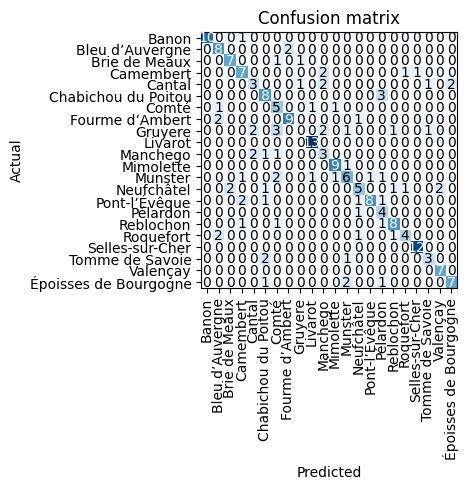

In [193]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Let's have a look at the top losses.

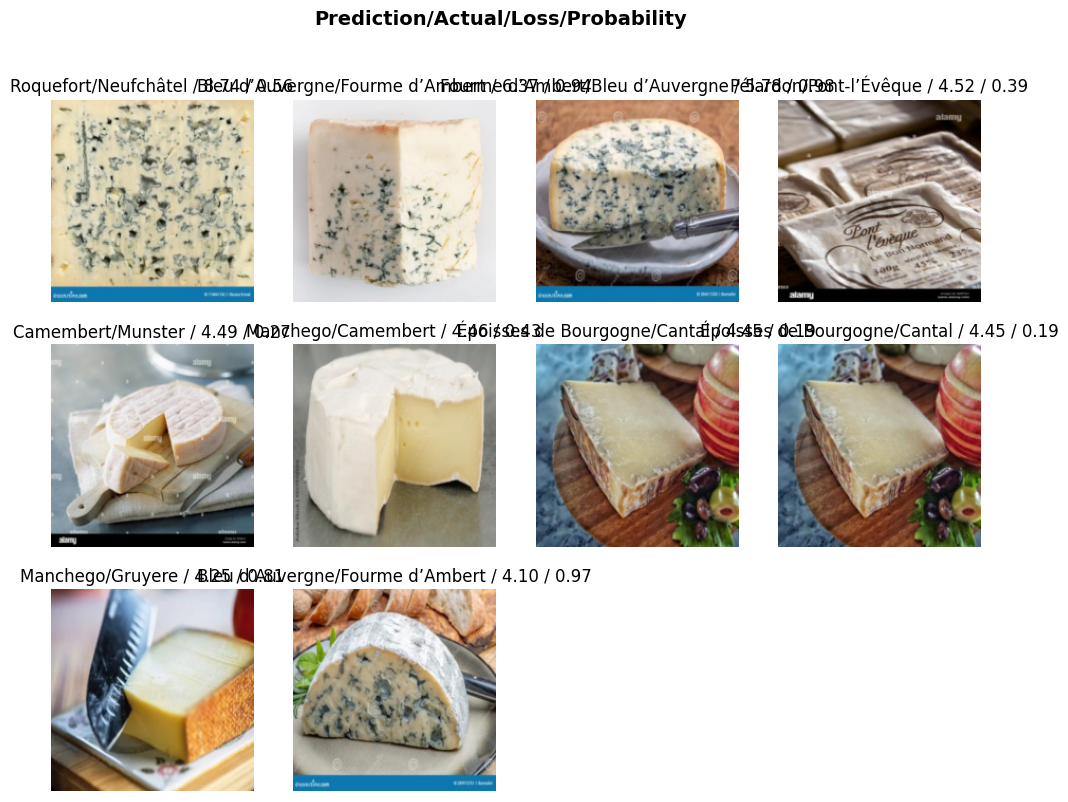

In [194]:
interp.plot_top_losses(10)

### All the same?
As expected similar cheese from the same group are difficult to distinguish.
Let's do some data cleaning.

For the Comte, Gruyere, Munster: pictures with the highest loss are thoses with little detail or other accessoires like bread or knifes.


In [195]:
from fastai.vision.widgets import *

In [136]:
files_to_clean=[]

In [196]:
cleaner = ImageClassifierCleaner(learn)
cleaner

### IMPORTANT: How to use the cleaner
For each category and train,valid select the images then run the following cell. The cleaner seems not to remember what was selected in other categories. 
We can also not run the above cell multiple times after we cleaned some files, as those will be missing. Instead we go through all categories and collect files to be deleted.
We do not change categories for now.

In [165]:
for idx in cleaner.delete(): 
    files_to_clean.append(cleaner.fns[idx])


In [169]:
for file in files_to_clean:
    try:
        file.unlink()
    except:
        pass

After a lot of examination I cleaned my dataset from 1100 files to 1029. I have run the following cells to create a copy of the cleaned data. For protection of the data, this cell is commented.

In [170]:
#!mkdir -p working/which_cheese_cleaned
#!cp -r working/which_cheese_first  working/which_cheese_cleaned